In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import seaborn as sns

sys.path.insert(1, '..')
import src.globals as globals
from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, cosine_sim2
from wrapper.metrics.evaluation_metrics import *
random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_60511/1535014153.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
n_attrs=20
max_iter=1000
n_clusters=25

In [3]:
score_fn = 'entropy'#'cosine_sim'#'cosine_sim2' #'top_k_reranking'#'entropy' #'entropy' #'content_fairness' 
probabilistic = False
globals.ALPHA = 0.01 #10.0 #0.01 # 0.1 
alpha = globals.ALPHA

# User parameters
drift = 0.05
attention_exp=-0.8
retrain = True

if retrain:
    str_retrain = "retrainTrue"
else:
    str_retrain = "retrainFalse"

experiment_name = 'supplementary'
this_experiment = f"{score_fn}_{alpha}_{str_retrain}"

In [4]:
binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')

# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

num_users = user_representation.shape[0] #len(user_representation)
num_items = item_representation.shape[1]#len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Loaded embeddings.
Loaded clusters.
Loaded clusters.
Number of items: 1682
Number of users: 943


/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
import math

user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

assert(len(inter_cluster_user_pairs) + len(intra_cluster_user_pairs) == (math.factorial(num_users) / (math.factorial(2)*math.factorial(num_users-2)))), "Bug with creating user pairs"

In [6]:
measurements = [
    InteractionMeasurement(),
    MSEMeasurement(),         
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    IntraClusterCosineSim(user_topic_mapping=user_item_cluster_mapping),
]

In [7]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_cluster_ids,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim2':
        config['score_fn'] = cosine_sim2
        requires_alpha = True
    elif score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [8]:
model = BubbleBurster(**config)

model.add_metrics(*measurements)

In [9]:
# Fair Model
train_timesteps=5
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


In [ ]:
run_timesteps=50
model.run(timesteps=run_timesteps)

100%|██████████| 50/50 [02:50<00:00,  3.41s/it]


In [ ]:
def create_measurements_df(model, model_name, train_timesteps, file_path):
    measurements = model.get_measurements()
    df = pd.DataFrame(measurements)
    df['state'] = 'train' # makes it easier to later understand which part was training
    df.loc[df['timesteps'] > train_timesteps, 'state'] = 'run'
    df['model'] = model_name
    
    return df

In [ ]:
import src
reload(src.utils)
from src.utils import *

if retrain:
    # Determine file name based on parameter values
    parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
    if requires_alpha:
        parameters += f'_{alpha}Lambda'
    # Save measurements
    measurements_dir = f'artefacts/{experiment_name}/measurements/'
    file_prefix = f'{model_name}_measurements'
    measurements_path = measurements_dir + file_prefix + parameters + '.csv'
    # np.set_printoptions(threshold=sys.maxsize)
    measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
    # measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()
elif not retrain:    
    # Determine file name based on parameter values
    parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
    if requires_alpha:
        parameters += f'_{alpha}Lambda'
    # Save measurements
    measurements_dir = f'artefacts/no_train_between_runs/{experiment_name}/measurements/'
    file_prefix = f'{model_name}_measurements'
    measurements_path = measurements_dir + file_prefix + parameters + '.csv'
    # np.set_printoptions(threshold=sys.maxsize)
    measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
else:
    assert(0), "ERROR"

In [ ]:
# Create df for parameters
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])

In [ ]:
measurements_df[10:20]

,interaction_histogram,mse,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,MeanCosSim_UserCluster,timesteps,state,model
10,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...",0.787903,0.053366,0.056159,"[[0.0], [0.5451729415379712], [0.0], [0.0], [0...",10,run,cosine_sim
11,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...",0.779537,0.056018,0.059282,"[[0.0], [0.5593710250243108], [0.0], [0.0], [0...",11,run,cosine_sim
12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...",0.770965,0.057733,0.061248,"[[0.0], [0.5726686281812172], [0.0], [0.0], [0...",12,run,cosine_sim
13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.762651,0.059198,0.062365,"[[0.0], [0.5887169338945962], [0.0], [0.0], [0...",13,run,cosine_sim
14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.754980,0.059953,0.063069,"[[0.0], [0.602997449531], [0.0], [0.0], [0.0],...",14,run,cosine_sim
15,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, ...",0.747766,0.060416,0.063305,"[[0.0], [0.6193715246814381], [0.0], [0.0], [0...",15,run,cosine_sim
16,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...",0.742179,0.060422,0.063299,"[[0.0], [0.6338315402675142], [0.0], [0.0], [0...",16,run,cosine_sim
17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.737704,0.060437,0.063325,"[[0.0], [0.6465958183180361], [0.0], [0.0], [0...",17,run,cosine_sim
18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.734303,0.060438,0.063244,"[[0.0], [0.657051749397237], [0.0], [0.0], [0....",18,run,cosine_sim
19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.731840,0.060355,0.063103,"[[0.0], [0.6646062143803905], [0.0], [0.0], [0...",19,run,cosine_sim


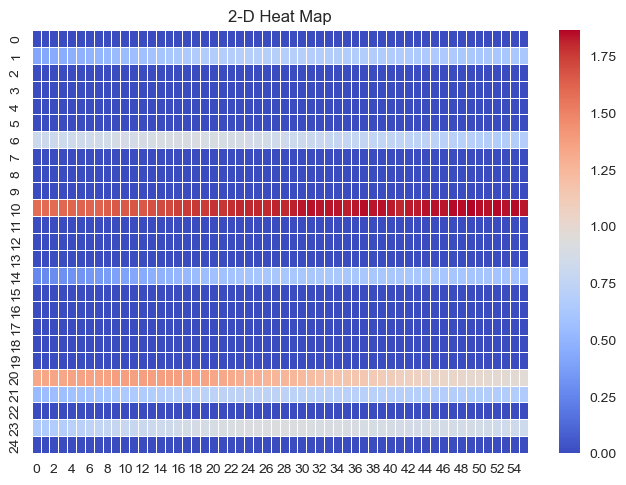

In [ ]:
cluster_degree_data = measurements_df['MeanCosSim_UserCluster'].to_numpy()
# data = np.array(cluster_degree_data)

# data.reshape((56,2))
# print(cluster_degree_data.flatten())
data = np.stack(cluster_degree_data, axis=0)
data = data.reshape((data.shape[0], data.shape[1]))
ax = sns.heatmap(data.T, linewidth = 0.5 , cmap = 'coolwarm' )
  
plt.title( "2-D Heat Map" )
plt.show()

# np.array(cluster_degree_data)
# np.array([[1,1],[1,1],[1,1]])
# print(data[:, 1])

# print(np.take(data, 5).shape)
# print(data.shape)

# import matplotlib.animation as animation
# n = cluster_degree_data.values[0].shape[0]
# number_of_frames = cluster_degree_data.size
# data = cluster_degree_data.values
# def update_hist(num, data):
#     plt.cla()
#     plt.hist(data[num][:, 1])
#     return
# fig = plt.figure()
# hist = plt.bar(np.arange(n), data[0][:, 1])
# anim = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ) )
# plt.show()

